In [1]:
#1.Importamos librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce

In [110]:
#2. Abrimos los dataset
data1=pd.read_csv("2017PurchasePricesDec.csv")
data2=pd.read_csv("BegInvFINAL12312016.csv")
data3=pd.read_csv("EndInvFINAL12312016.csv")
data4=pd.read_csv("InvoicePurchases12312016.csv",parse_dates=["PODate","PayDate"])
data5=pd.read_csv("PurchasesFINAL12312016.csv",parse_dates=["PODate","PayDate","InvoiceDate","ReceivingDate"])
data6=pd.read_csv("SalesFINAL12312016.csv",parse_dates=["SalesDate"])
datas=[data1,data2,data3,data4,data5,data6]

In [6]:
#3. Analizamos datasetes
for data in datas:
    print(data.columns,data.shape)
    print(data.isnull().sum())

Index(['Brand', 'Description', 'Price', 'Size', 'Volume', 'Classification',
       'PurchasePrice', 'VendorNumber', 'VendorName'],
      dtype='object') (12261, 9)
Brand             0
Description       1
Price             0
Size              1
Volume            1
Classification    0
PurchasePrice     0
VendorNumber      0
VendorName        0
dtype: int64
Index(['InventoryId', 'Store', 'City', 'Brand', 'Description', 'Size',
       'onHand', 'Price', 'startDate'],
      dtype='object') (206529, 9)
InventoryId    0
Store          0
City           0
Brand          0
Description    0
Size           0
onHand         0
Price          0
startDate      0
dtype: int64
Index(['InventoryId', 'Store', 'City', 'Brand', 'Description', 'Size',
       'onHand', 'Price', 'endDate'],
      dtype='object') (224489, 9)
InventoryId       0
Store             0
City           1284
Brand             0
Description       0
Size              0
onHand            0
Price             0
endDate           0
dtype: in

In [36]:
#4. Rellenamos valores faltantes
#  A. nulo de data1 (analizado desde excel con el valor semejante, mismo vendebor, mismo PurchasePrice, y ID similar)
h=0
k=""
m=0
mm=0
for i in range(0,len(data1)):
    if pd.isnull(data1.iloc[i,3]):
        h=data1.iloc[i,6]
        k=data1.iloc[i,8]
        m=i
        print("la ubicacion del valor faltantes es: ",m)
    if data1.iloc[i,6]==h and data1.iloc[i,8]==k:
        mm=i
        print("la ubicacion del valor similar es: ",mm)
data1.iloc[m,1]="Bacardi"
data1.iloc[m,2]=data1.iloc[mm,2]
data1.iloc[m,3]=data1.iloc[mm,3]
data1.iloc[m,4]=data1.iloc[mm,4]
print(data1.iloc[m,:])        


la ubicacion del valor faltantes es:  7915
la ubicacion del valor similar es:  7915
la ubicacion del valor similar es:  10418
Brand                                    4202
Description                           Bacardi
Price                                   13.99
Size                                    750mL
Volume                                    750
Classification                              1
PurchasePrice                           11.19
VendorNumber                              480
VendorName        BACARDI USA INC            
Name: 7915, dtype: object


In [39]:
#4. Rellenamos valores faltantes
#  B. nulo de data5
for i in range(0,len(data5)):
    if pd.isnull(data5.iloc[i,4]):
        #h=data1.iloc[i,6]
        #k=data1.iloc[i,8]
        m=data5.iloc[i,2]
        print("la ubicacion del valor faltantes es: ",m)
        for j in range(0,len(data1)):
            if data1.iloc[j,0]==m:
                data5.iloc[i,4]=data1.iloc[j,3]

la ubicacion del valor faltantes es:  3121
la ubicacion del valor faltantes es:  5678
la ubicacion del valor faltantes es:  15365


In [41]:
#4. Rellenamos valores faltantes
#  C. nulo de data3 
mascara_nulos = data3[data3['City'].isnull()]
nulos=[]
for i in range(0,len(mascara_nulos)):
    h=mascara_nulos.iloc[i,0]
    nulos.append(h)
stores=[]
for j in nulos:
    cadena = j
    primeras_dos_letras = cadena[0] + cadena[1]
    if primeras_dos_letras not in stores:
        stores.append(primeras_dos_letras)
stores = [s.replace("_", "") for s in stores]
print("Stores sin localidad:",stores)  
data3["City"]=data3["City"].fillna("sin_localidad")
data_city=data3.groupby("Store").agg({"City": "first"}).reset_index()

#  D. nulos data4 eliminamos columna Aproval (es una columna que no usaremos)
data4=data4.drop(columns="Approval",inplace=True)

Stores sin localidad: ['46']


Para definir el stock optimo utilizamos la siguiente formula: 
Para ello necesitamos definir la media y desviacion y standar del tiempo de reposición y de las ventas

Index(['InventoryId', 'Store', 'Brand', 'Description', 'Size', 'PurchasePrice',
       'VendorName', 'Quantity', 'lead_time_mean', 'lead_time_std'],
      dtype='object')
Index(['InventoryId', 'Store', 'Brand', 'Description', 'Size', 'VendorName',
       'SalesPrice', 'Sales_Quantity_mean', 'Sales_Quantity_std'],
      dtype='object')


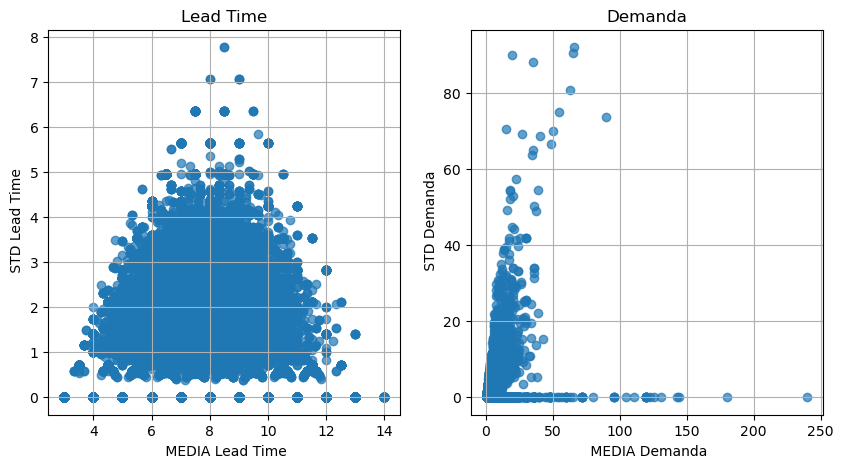

In [43]:
#5. DEFINIMOS MEDIA Y DESVIACION STANDAR DEL TIEMPO DE REPOSICION
#  A. Tabla Compras (data5) 
#     a. Defimos el lead time para cada producto en cada compra
data5["lead_time"]=(data5["ReceivingDate"]-data5["PODate"]).dt.days

#     b. Agrupamos compras por producto → defimos la media y std del lead time
lead_time = data5.groupby("InventoryId").agg({
    "Store": "first",
    "Brand": "first",
    "Description": "first",
    "Size": "first",
    "PurchasePrice":"first",
    "VendorName":"first",
    "Quantity":"sum",
    "lead_time": ["mean", "std"]
}).reset_index()
lead_time.columns = ["InventoryId", "Store", "Brand", "Description","Size","PurchasePrice","VendorName","Quantity","lead_time_mean", "lead_time_std"]
print(lead_time.columns)
lead_time["lead_time_std"] = lead_time["lead_time_std"].fillna(0)

#  B. Tabla Vemtas (data6) 
#     a. Agrupamos ventas de producto y día → sumar cuántas unidades se vendieron ese día por producto
ventas_diarias = data6.groupby(["InventoryId", "SalesDate"]).agg({
    "Store": "first",
    "Brand": "first",
    "Description": "first",
    "Size": "first",
    "VendorName":"first",
    "SalesPrice": "mean",
    "SalesQuantity": "sum"
}).reset_index()


#    b. Luego, sacamos la media y std de las ventas diaria de cada producto
estadisticas_vtas_por_producto = ventas_diarias.groupby("InventoryId").agg({
    "Store": "first",
    "Brand": "first",
    "Description": "first",
    "Size": "first",
    "VendorName":"first",
    "SalesPrice": "mean",
    "SalesQuantity": ["mean", "std"]
}).reset_index()
estadisticas_vtas_por_producto.columns = ["InventoryId", "Store", "Brand", "Description","Size","VendorName","SalesPrice","Sales_Quantity_mean","Sales_Quantity_std"]
print(estadisticas_vtas_por_producto.columns)
estadisticas_vtas_por_producto["Sales_Quantity_std"] = estadisticas_vtas_por_producto["Sales_Quantity_std"].fillna(0)

#GRAFICOS MEDIA Y STD DE CADA TABLA PARA VER LA VIARABILIDAD
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axs[0].scatter(lead_time["lead_time_mean"], lead_time["lead_time_std"], alpha=0.7)
axs[0].set_title("Lead Time")
axs[0].set_ylabel(" STD Lead Time")
axs[0].set_xlabel(" MEDIA Lead Time")
axs[0].grid(True)

axs[1].scatter(estadisticas_vtas_por_producto["Sales_Quantity_mean"], estadisticas_vtas_por_producto["Sales_Quantity_std"], alpha=0.7)
axs[1].set_title("Demanda")
axs[1].set_ylabel(" STD Demanda")
axs[1].set_xlabel(" MEDIA Demanda")
axs[1].grid(True)

plt.show()

In [45]:
# 6. UNIMOS TABLAS PARA TENER EN UNA MISMA TABLA: STOCK INICIAL, STOCK FINAL Y MEDIA Y DESVIACION STANDAR DE DEMANDA Y LEAD_TIME
#  A. Tablas inventario: Unimos inventario al 1 de enero con inventario al 31 de diciembre
#   a. Unimos tablas con merge
merge_data = pd.merge(
    data2,
    data3,
    on="InventoryId",how="outer",suffixes=("_inicio", "_fin")
)
#   b. Rellenamos infomracion de los InventoryId
columnas_base = ['Store', 'City', 'Brand', 'Description', 'Size', 'Price']
for col in columnas_base:
    merge_data[col] = merge_data[f"{col}_inicio"].combine_first(merge_data[f"{col}_fin"]) #Primero el valor de la columna con sufijo _inicio .Si ese valor es NaN, toma el de la columna con sufijo _fin

cols_a_eliminar = [f"{col}_inicio" for col in columnas_base] + [f"{col}_fin" for col in columnas_base] + ["startDate", "endDate"]
merge_data.drop(cols_a_eliminar, axis=1, inplace=True)

# C. Remplaazamos nulos de inventario por cero
merge_data["onHand_inicio"] = merge_data["onHand_inicio"].fillna(0)
merge_data["onHand_fin"] = merge_data["onHand_fin"].fillna(0)

#D. Incorporamos VendorName a la tabla
merge_dataA = pd.merge(
    merge_data,
    data1[["Brand","VendorName"]],
    on="Brand",how="left"
)

print(merge_dataA.isnull().sum())

InventoryId      0
onHand_inicio    0
onHand_fin       0
Store            0
City             0
Brand            0
Description      0
Size             0
Price            0
VendorName       0
dtype: int64


In [47]:
# 6. UNIMOS TABLAS PARA TENER EN UNA MISMA TABLA: STOCK INICIAL, STOCK FINAL Y MEDIA Y DESVIACION STANDAR DE DEMANDA Y LEAD_TIME
#  B. Unimos inventarios(merge_data) con compras (lead_time) 
#    a. Unimos tablas 
merge_data2 = pd.merge(
    merge_dataA,
    lead_time,
    on="InventoryId",how="outer",suffixes=("_inicio", "_fin")
)
#    b. Rellenamos infomracion de los InventoryId
columnas_base = ['Store', 'Brand', 'Description','Size',"VendorName"]
for col in columnas_base:
    merge_data2[col] = merge_data2[f"{col}_inicio"].combine_first(merge_data2[f"{col}_fin"])  #Primero el valor de la columna con sufijo _inicio .Si ese valor es NaN, toma el de la columna con sufijo _fin

cols_a_eliminar = [f"{col}_inicio" for col in columnas_base] + [f"{col}_fin" for col in columnas_base] 
merge_data2.drop(cols_a_eliminar, axis=1, inplace=True)
merge_data2["onHand_inicio"] = merge_data2["onHand_inicio"].fillna(0)
merge_data2["onHand_fin"] = merge_data2["onHand_fin"].fillna(0)


#    c. Remplaazamos nulos de City (ya que la tabla lea_time (data5) no tiene la columa City)
merge_data3 = pd.merge(merge_data2,
    data_city,
    on="Store",
    how="left",
    suffixes=("", "_new")
)
merge_data3.drop(columns="City", inplace=True)
merge_data3.rename(columns={"City_new": "City"}, inplace=True)

#   d. Remplaazamos nulos de Price (ya que la tabla merge_dataA (data1 y data5) no tiene la columa Price)
merge_data3A = pd.merge(merge_data3,
    data1[["Brand","Price","PurchasePrice"]],
    on="Brand",
    how="left",
    suffixes=("", "_new")
)
merge_data3A.drop(columns=["Price","PurchasePrice"], inplace=True)
merge_data3A.rename(columns={"Price_new": "Price","PurchasePrice_new": "PurchasePrice"}, inplace=True)
print(merge_data3A.columns)

print(merge_data3A.isnull().sum())


Index(['InventoryId', 'onHand_inicio', 'onHand_fin', 'Quantity',
       'lead_time_mean', 'lead_time_std', 'Store', 'Brand', 'Description',
       'Size', 'VendorName', 'City', 'Price', 'PurchasePrice'],
      dtype='object')
InventoryId           0
onHand_inicio         0
onHand_fin            0
Quantity          30482
lead_time_mean    30482
lead_time_std     30482
Store                 0
Brand                 0
Description           0
Size                  0
VendorName            0
City                  0
Price                 0
PurchasePrice         0
dtype: int64


In [65]:
# 6. UNIMOS TABLAS PARA TENER EN UNA MISMA TABLA: STOCK INICIAL, STOCK FINAL Y MEDIA Y DESVIACION STANDAR DE DEMANDA Y LEAD_TIME
#  B. Unimos inventarios+Led_time(merge_data3A) con ventas (estadisticas_vtas_por_producto) 
#    a. Unimos tablas 
merge_data4 = pd.merge(
    merge_data3A,
    estadisticas_vtas_por_producto,
    on="InventoryId",how="outer",suffixes=("_inicio", "_fin")
)

#    b. Rellenamos infomracion de los InventoryId
columnas_base = ['Store', 'Brand', 'Description','Size','VendorName']
for col in columnas_base:
    merge_data4[col] = merge_data4[f"{col}_inicio"].combine_first(merge_data4[f"{col}_fin"])

cols_a_eliminar = [f"{col}_inicio" for col in columnas_base] + [f"{col}_fin" for col in columnas_base] 
merge_data4.drop(cols_a_eliminar, axis=1, inplace=True)

merge_data4["Store"]=merge_data4["Store"].astype(str)
merge_data4["Brand"]=merge_data4["Brand"].astype(str)

print(merge_data4.isnull().sum())

InventoryId                 0
onHand_inicio               0
onHand_fin                  0
Quantity                30482
lead_time_mean          30482
lead_time_std           30482
City                        0
Price                       0
PurchasePrice               0
SalesPrice             106258
Sales_Quantity_mean    106258
Sales_Quantity_std     106258
Store                       0
Brand                       0
Description                 0
Size                        0
VendorName                  0
dtype: int64


In [71]:
# 7. ESTIMACION DE LEAD_TIME Y DEMANDA DIARIA DE PRODUCTOS SIN VENTAS O SIN COMPRAS
#  A. Lead_time
#    a. Configuración de columnas
onehot_cols  = ["City", "Store","Size"] # pocas categorías
target_cols  = ["VendorName", "Brand"] # muchas categorías
num_cols     = ["Price", "PurchasePrice","onHand_inicio","onHand_fin"] # columnas numéricas
columnas_rellenar = ["Quantity", "lead_time_mean", "lead_time_std"]

#   b. Aplicamos la funcion de estimacion con maching learning (la funcion se encuenta al final del dataset) 
for col in columnas_rellenar:
    rellenar_semejantes(merge_data4, col, onehot_cols, target_cols, num_cols)


✅ 'Quantity' completado con Random Forest + encoding mixto.
✅ 'lead_time_mean' completado con Random Forest + encoding mixto.
✅ 'lead_time_std' completado con Random Forest + encoding mixto.


In [75]:
# 7. ESTIMACION DE LEAD_TIME Y DEMANDA DIARIA DE PRODUCTOS SIN VENTAS O SIN COMPRAS
#  B. Demanda diaria
#    a. Configuración de columnas
onehot_cols  = ["City", "Store","Size"] # pocas categorías
target_cols  = ["VendorName", "Brand"] # muchas categorías
num_cols     = ["Price", "PurchasePrice","onHand_inicio","onHand_fin","Quantity","lead_time_mean"]
columnas_rellenar = ["SalesPrice", "Sales_Quantity_mean", "Sales_Quantity_std"]


#    b. Aplicamos la funcion de estimacion con maching learning (la funcion se encuenta al final del dataset) 
for col in columnas_rellenar:
    rellenar_semejantes(merge_data4, col, onehot_cols, target_cols, num_cols)

✅ 'SalesPrice' completado con Random Forest + encoding mixto.
✅ 'Sales_Quantity_mean' completado con Random Forest + encoding mixto.
✅ 'Sales_Quantity_std' completado con Random Forest + encoding mixto.


In [88]:
print(merge_data4.isnull().sum())

InventoryId            0
onHand_inicio          0
onHand_fin             0
Quantity               0
lead_time_mean         0
lead_time_std          0
City                   0
Price                  0
PurchasePrice          0
SalesPrice             0
Sales_Quantity_mean    0
Sales_Quantity_std     0
Store                  0
Brand                  0
Description            0
Size                   0
VendorName             0
dtype: int64


In [78]:
merge_data4.to_excel("data_final2.xlsx")

In [5]:
merge_data4=pd.read_excel("data_final2.xlsx")

In [6]:
# 8. DEFINIMOS STOCK ÓPTIMO AL 1 DE ENERO
nivel_seguridad=1.65
merge_data4["Stock_base_0101"]=merge_data4["Sales_Quantity_mean"]*merge_data4["lead_time_mean"]
merge_data4["Stock_seguridad_0101"]=np.sqrt((np.square(merge_data4["Sales_Quantity_mean"])*np.square(merge_data4["lead_time_std"]))+(np.square(merge_data4["Sales_Quantity_std"])*np.square(merge_data4["lead_time_mean"])))  
merge_data4["Stock_seguridad_0101"] = merge_data4["Stock_seguridad_0101"].clip(lower=0) #que no alla negativos ni nulos
merge_data4["Stock_optimo_0101"]= merge_data4["Stock_base_0101"] + nivel_seguridad * merge_data4["Stock_seguridad_0101"]

In [124]:
print(merge_data4.columns)

Index(['InventoryId', 'onHand_inicio', 'onHand_fin', 'Quantity',
       'lead_time_mean', 'lead_time_std', 'City', 'Price', 'PurchasePrice',
       'SalesPrice', 'Sales_Quantity_mean', 'Sales_Quantity_std', 'Store',
       'Brand', 'Description', 'Size', 'VendorName', 'Stock_base_0101',
       'Stock_seguridad_0101', 'Stock_optimo_0101', 'Sales_Quantity_mean_3112',
       'Sales_Quantity_3112', 'Stock_base_3112', 'Stock_seguridad_3112',
       'Stock_optimo_3112'],
      dtype='object')


In [7]:
# 9. ESTIMACION DE DEMANDA AL 31 DE DICIEMBRE
merge_data4["Sales_Quantity_3112"] = (merge_data4["onHand_inicio"] + merge_data4["Quantity"] - merge_data4["onHand_fin"]
).clip(lower=0)

merge_data4["Sales_Quantity_mean_3112"] = merge_data4["Sales_Quantity_3112"] / 365

In [8]:
# 10. DEFINIMOS STOCK ÓPTIMO AL 31 DE DICIEMBRE
nivel_seguridad=1.65
merge_data4["Stock_base_3112"]=merge_data4["Sales_Quantity_mean_3112"]*merge_data4["lead_time_mean"]
merge_data4["Stock_seguridad_3112"]=np.sqrt((np.square(merge_data4["Sales_Quantity_mean_3112"])*np.square(merge_data4["lead_time_std"]))+(np.square(merge_data4["Sales_Quantity_std"])*np.square(merge_data4["lead_time_mean"])))  
merge_data4["Stock_seguridad_3112"] = merge_data4["Stock_seguridad_3112"].clip(lower=0) #que no alla negativos ni nulos
merge_data4["Stock_optimo_3112"]= merge_data4["Stock_base_3112"] + nivel_seguridad * merge_data4["Stock_seguridad_3112"]

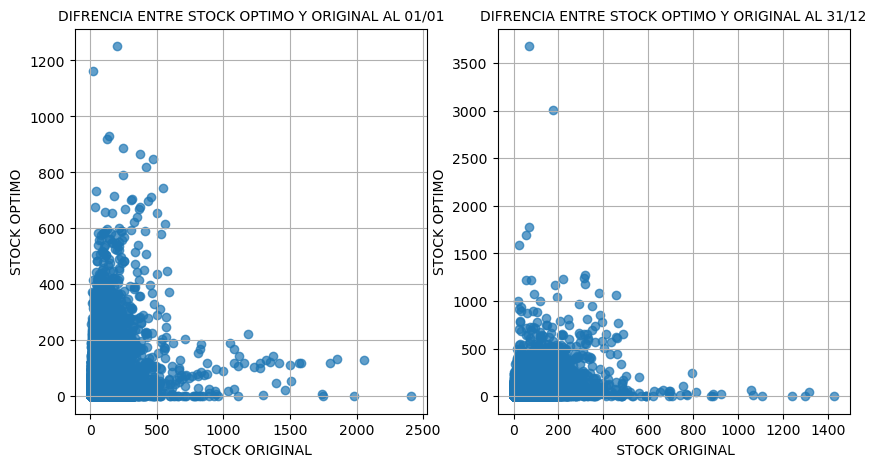

In [132]:
# 11. ANÁLISIS EXPLORATORIO DE DATOS
#  A. Diferencia entre stock óptimo y stock original
#    a. Hacemos scatter plot para ver la diferencias de stocks
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axs[0].scatter(merge_data4["Stock_optimo_0101"], merge_data4["onHand_inicio"], alpha=0.7)
axs[0].set_title("DIFRENCIA ENTRE STOCK OPTIMO Y ORIGINAL AL 01/01",size=10)
axs[0].set_ylabel("STOCK OPTIMO")
axs[0].set_xlabel(" STOCK ORIGINAL")
axs[0].grid(True)

axs[1].scatter(merge_data4["Stock_optimo_3112"], merge_data4["onHand_fin"], alpha=0.7)
axs[1].set_title("DIFRENCIA ENTRE STOCK OPTIMO Y ORIGINAL AL 31/12",size=10)
axs[1].set_ylabel("STOCK OPTIMO")
axs[1].set_xlabel(" STOCK ORIGINAL")
axs[1].grid(True)

plt.show()

-1146.9539237976471 2408.9870413595036
-3605.2250716222566 1425.4823156721702


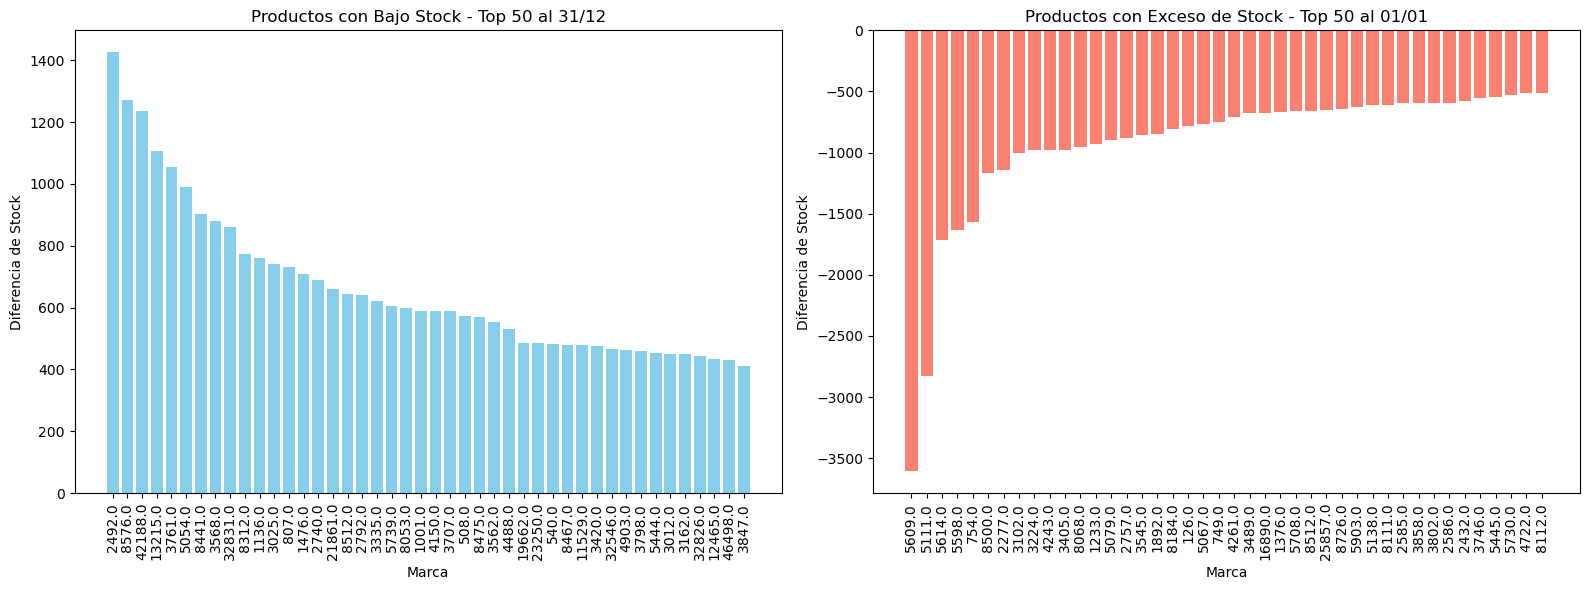

In [49]:
# 11. ANÁLISIS EXPLORATORIO DE DATOS
#  B. Productos con mucho stock y con poco stock 
#    a. Definimos diferencias de stock
merge_data4["Difrencia_stock_0101"]=merge_data4["Stock_optimo_0101"]-merge_data4["onHand_inicio"]
merge_data4["Difrencia_stock_3112"]=merge_data4["Stock_optimo_3112"]-merge_data4["onHand_fin"]
print(merge_data4["Difrencia_stock_0101"].min(),merge_data4["Difrencia_stock_0101"].max())
print(merge_data4["Difrencia_stock_3112"].min(),merge_data4["Difrencia_stock_3112"].max())

#    b.Tomamos primeros 50 productos con bajo stock y con exceso de stock
merge_data4["Brand"]= merge_data4["Brand"].astype(str)
merge_data4_A= merge_data4.sort_values("Difrencia_stock_3112", ascending=False).head(50).copy() # primer 50 productos con bajo stock
merge_data4_B= merge_data4.sort_values("Difrencia_stock_3112", ascending=True).head(50).copy()  # primer 50 productos con exceso de stock

#    c.Graficamos con grafico de barras
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Gráfico 1: Bajo stock al 31/12
axs[0].bar(merge_data4_A["Brand"], merge_data4_A["Difrencia_stock_3112"], color='skyblue')
axs[0].set_title('Productos con Bajo Stock - Top 50 al 31/12')
axs[0].set_xlabel('Marca')
axs[0].set_ylabel('Diferencia de Stock')
axs[0].tick_params(axis='x', rotation=90)

# Gráfico 2: Exceso stock al 31/12
axs[1].bar(merge_data4_B["Brand"], merge_data4_B["Difrencia_stock_3112"], color='salmon')
axs[1].set_title('Productos con Exceso de Stock - Top 50 al 01/01')
axs[1].set_xlabel('Marca')
axs[1].set_ylabel('Diferencia de Stock')
axs[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()


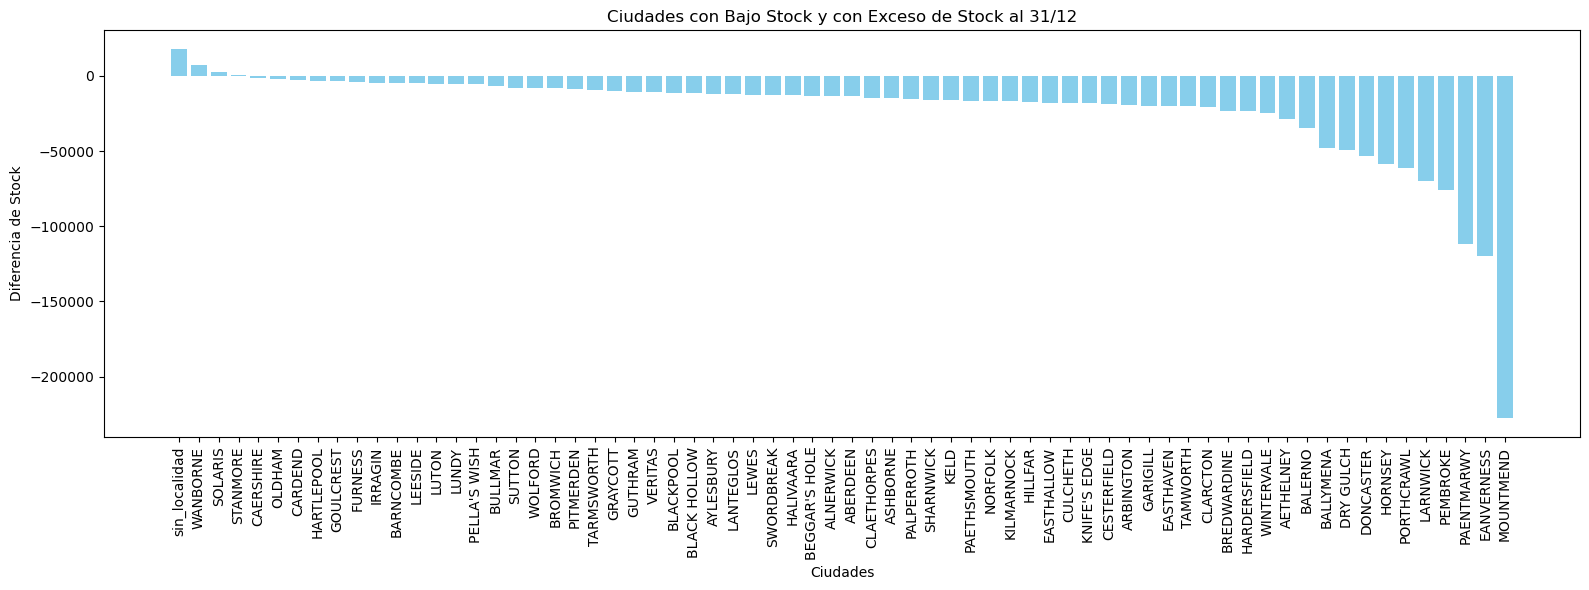

In [73]:
# 11. ANÁLISIS EXPLORATORIO DE DATOS
#  B. Ciudades con mucho stock y con poco stock 
#    a. Definimos diferencias de stock
merge_data4_city=merge_data4.groupby("City")["Difrencia_stock_3112"].sum().reset_index()

#    b.Tomamos primeros 50 productos con bajo stock y con exceso de stock

merge_data4_city_A= merge_data4_city.sort_values("Difrencia_stock_3112", ascending=False).copy() # primer 50 productos con bajo stock
merge_data4_city_B= merge_data4_city.sort_values("Difrencia_stock_3112", ascending=True).copy()  # primer 50 productos con exceso de stock

#    c.Graficamos con grafico de barras
plt.subplots(figsize=(16, 6))

# Gráfico 1: Diferencia de stock al 31/12
plt.bar(merge_data4_city_A["City"], merge_data4_city_A["Difrencia_stock_3112"], color='skyblue')
plt.title('Ciudades con Bajo Stock y con Exceso de Stock al 31/12')
plt.xlabel('Ciudades')
plt.ylabel('Diferencia de Stock')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


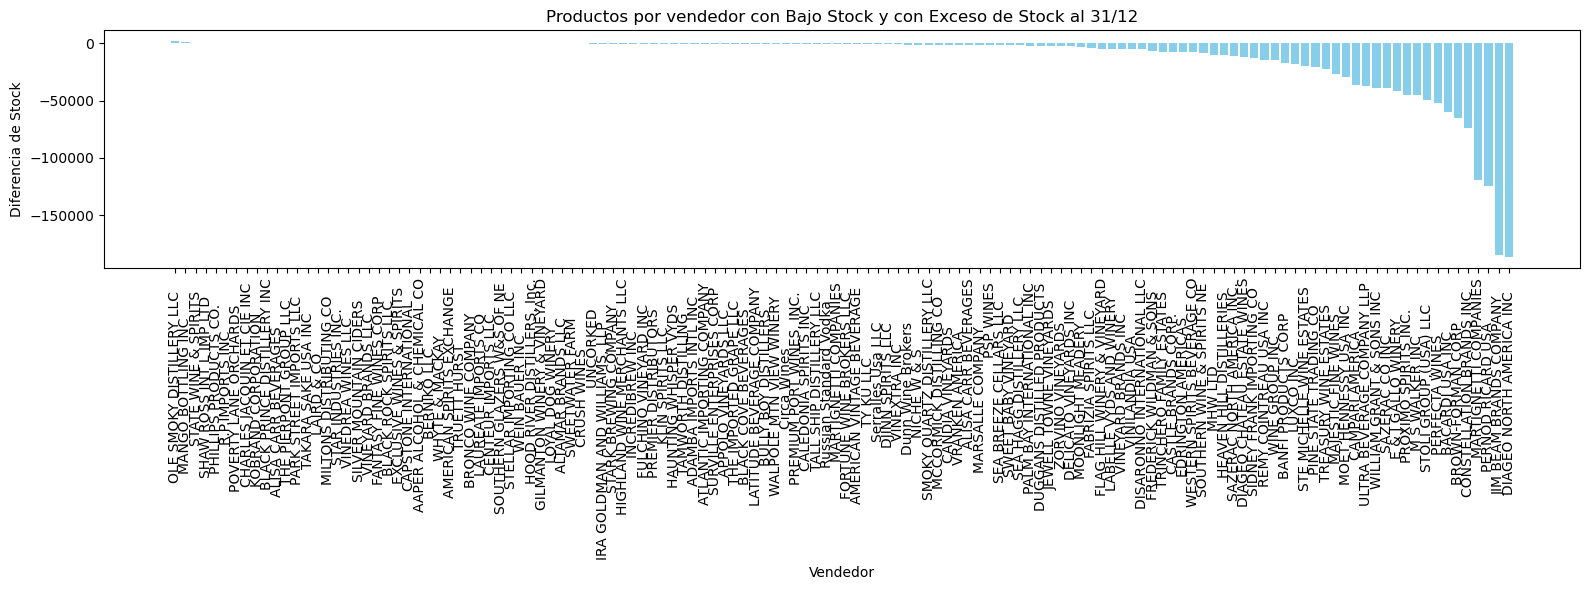

In [85]:
# 11. ANÁLISIS EXPLORATORIO DE DATOS
#  C. Productos por vendedor con mucho stock y con poco stock 
#    a. Agrupamos por vendedor name
merge_data4_vendor=merge_data4.groupby("VendorName")["Difrencia_stock_3112"].sum().reset_index()

#    b.Tomamos primeros 50 productos con bajo stock y con exceso de stock

merge_data4_vendor_A= merge_data4_vendor.sort_values("Difrencia_stock_3112", ascending=False).copy() # primer 50 productos con bajo stock
merge_data4_vendor_B= merge_data4_vendor.sort_values("Difrencia_stock_3112", ascending=True).copy()  # primer 50 productos con exceso de stock

#    c.Graficamos con grafico de barras
plt.subplots(figsize=(16, 6))

# Gráfico 1: Diferencia de stock al 31/12
plt.bar(merge_data4_vendor_A["VendorName"], merge_data4_vendor_A["Difrencia_stock_3112"], color='skyblue')
plt.title('Productos por vendedor con Bajo Stock y con Exceso de Stock al 31/12')
plt.xlabel('Vendedor')
plt.ylabel('Diferencia de Stock')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


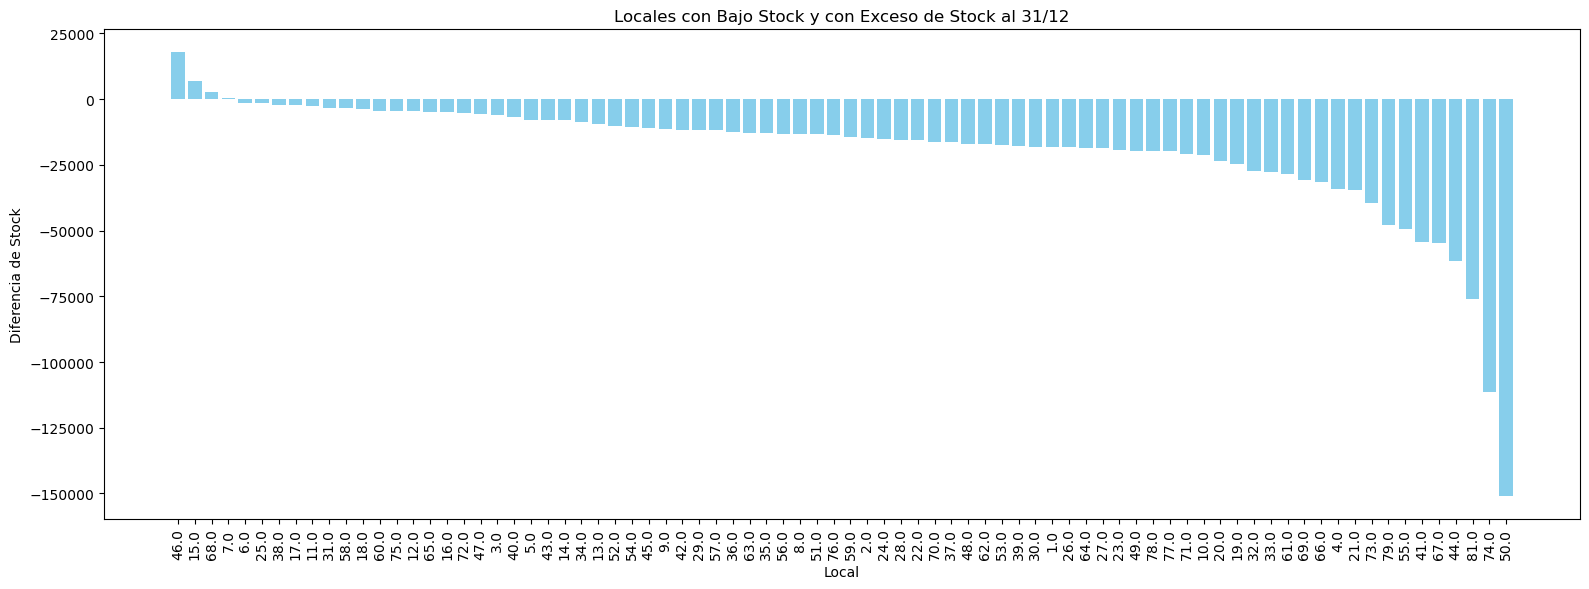

In [87]:
# 11. ANÁLISIS EXPLORATORIO DE DATOS
#  B. Productos por vendedor con mucho stock y con poco stock 
#    a. Agrupamos por vendedor name
merge_data4["Store"]= merge_data4["Store"].astype(str)
merge_data4_vendor=merge_data4.groupby("Store")["Difrencia_stock_3112"].sum().reset_index()

#    b.Tomamos primeros 50 productos con bajo stock y con exceso de stock

merge_data4_store_A= merge_data4_vendor.sort_values("Difrencia_stock_3112", ascending=False).copy() # primer 50 productos con bajo stock
merge_data4_store_B= merge_data4_vendor.sort_values("Difrencia_stock_3112", ascending=True).copy()  # primer 50 productos con exceso de stock

#    c.Graficamos con grafico de barras
plt.subplots(figsize=(16, 6))

# Gráfico 1: Diferencia de stock al 31/12
plt.bar(merge_data4_store_A["Store"], merge_data4_store_A["Difrencia_stock_3112"], color='skyblue')
plt.title('Locales con Bajo Stock y con Exceso de Stock al 31/12')
plt.xlabel('Local')
plt.ylabel('Diferencia de Stock')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


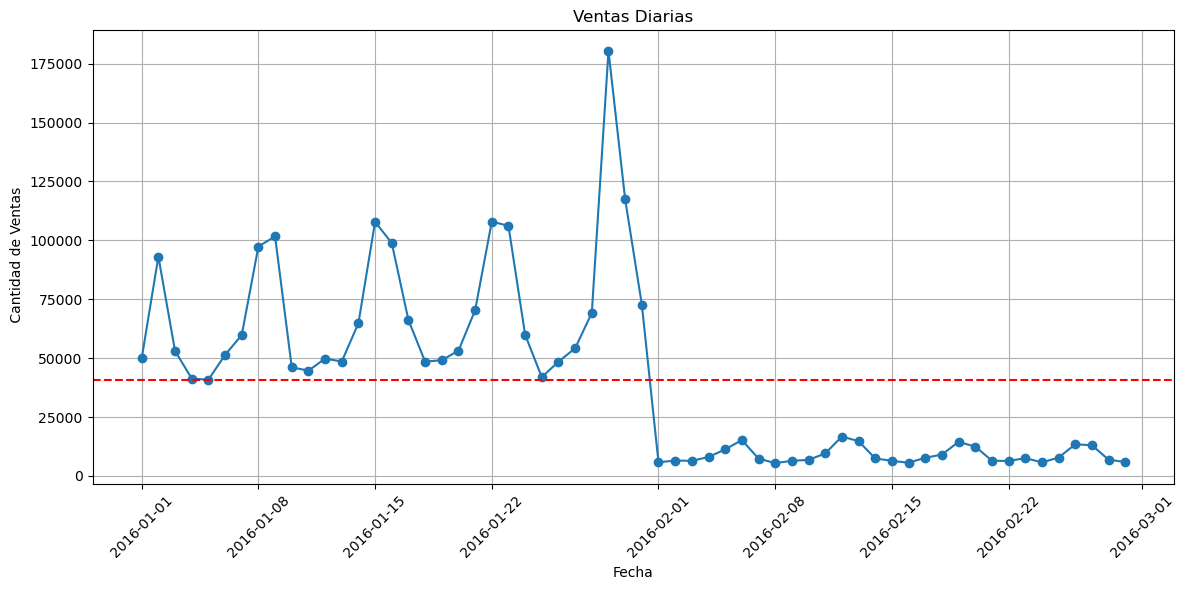

In [136]:
ventas_diarias = data6.groupby('SalesDate')['SalesQuantity'].sum()
ventas_diarias1=ventas_diarias.reset_index()
promedio=ventas_diarias.mean()
ventas_diarias1["promedio"]=promedio

# Graficar
plt.figure(figsize=(12, 6))
plt.plot(ventas_diarias.index, ventas_diarias.values, marker='o')
plt.axhline(y=promedio, color='red', linestyle='--', label=f'Promedio: {promedio:.2f}')
plt.title('Ventas Diarias')
plt.xlabel('Fecha')
plt.ylabel(' Cantidad de Ventas')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
#FUNCIONES

In [69]:
# B. Seleccionamos variables predictoras
features = ["City", "Store", "VendorName", "Price", "PurchasePrice", "Brand", "Size","onHand_inicio","onHand_fin","lead_time_mean"]
# C. Columnas categóricas y numéricas
onehot_cols  = ["City", "Store","VendorName"] # pocas categorías
target_cols  = ["Brand"]  # muchas categorías
num_cols = ["Price", "PurchasePrice", "lead_time_mean", "Sales_Quantity_mean"]  # Columnas numéricas

def rellenar_semejantes(df, columna_objetivo, onehot_cols, target_cols, num_cols):
    df_train = df[df[columna_objetivo].notna()].copy()
    df_pred  = df[df[columna_objetivo].isna()].copy()

    # Verificación
    if df_train.empty or df_pred.empty:
        print(f"⚠️  No se puede predecir '{columna_objetivo}': no hay suficientes datos.")
        return

    # Target encoding fuera del ColumnTransformer
    encoder = ce.TargetEncoder(cols=target_cols)
    df_train.loc[:, target_cols] = encoder.fit_transform(df_train[target_cols], df_train[columna_objetivo])
    df_pred.loc[:, target_cols]  = encoder.transform(df_pred[target_cols])

    # ColumnTransformer: OneHot para categóricas de baja cardinalidad, imputación para numéricas
    preprocessor = ColumnTransformer([
        ("ohe", OneHotEncoder(handle_unknown="ignore"), onehot_cols),
        ("num", SimpleImputer(strategy="mean"), num_cols)
    ], remainder="passthrough")

    # Modelo
    model = Pipeline([
        ("pre", preprocessor),
        ("reg", RandomForestRegressor(n_estimators=50, max_features="sqrt", random_state=42, n_jobs=-1))
    ])

    # Variables predictoras
    features = onehot_cols + target_cols + num_col

    # Entrenamiento y predicción
    model.fit(df_train[features], df_train[columna_objetivo])
    predicciones = model.predict(df_pred[features])
    df.loc[df_pred.index, columna_objetivo] = predicciones

    print(f"✅ '{columna_objetivo}' completado con Random Forest + encoding mixto.")
